## Table of Contents

1. [Introduction](#intro)
2. [Libraries](#libs)
3. [Data Exploration](#dataexp)
4. [Analysis](#analysis)
    1. [Insights with regard to pricing](#pricing)
    2. [Takeaways & Insights from the Data](#takeaway)
5. [Test Running Time](#time)
    1. [Reduced test time suggestion](#reducedtime)
6. [Conclusion](#conclusion)

# Data Challenge 2 - Pricing Test <a name="intro"></a>



## Goal
Pricing optimization is, non surprisingly, another area where data science can provide huge value.

The goal here is to evaluate whether a pricing test running on the site has been successful. As always, you should focus on user segmentation and provide insights about segments who behave differently as well as any other insights you might find.

## Challenge Description
Company XYZ sells a software for \$ 39. 

Since revenue has been flat for some time, the VP of Product has decided to run a test increasing the price. She hopes that this would increase revenue. In the experiment, 66\% of the users have seen the old price, while a random sample of 33\% users a higher price.

The test has been running for some time and the VP of Product is interested in understanding how it went and whether it would make sense to increase the price for all the users. Especially she asked you the following questions:

1. Should the company sell its software for \$ 39 or \$ 59?

2. The VP of Product is interested in having a holistic view into user behavior, especially focusing on actionable insights that might increase conversion rate. What are your main findings looking at the data?

3. The VP of Product feels that the test has been running for too long and he should have been able to get statistically significant results in a shorter time. Do you agree with her intuition? After how many days you would have stopped the test? Please, explain why.

## Data
We have two tables downloadable by clicking here. The two tables are:

### "test_results" - data about the test
Columns:

user_id : the Id of the user. Can be joined to user_id in user_table

timestamp : the date and time when the user hit for the first time company XYZ webpage. It is in user local time

source : marketing channel that led to the user coming to the site. It can be: ads-["google", "facebook", "bing", "yahoo", "other"]. That is, user coming from google ads, yahoo ads, etc. seo - ["google", "facebook", "bing", "yahoo", "other"]. That is, user coming from google search, yahoo, facebook, etc.

friend_referral : user coming from a referral link of another user

direct_traffic: user coming by directly typing the address of the site on the browser

device : user device. Can be mobile or web

operative_system : user operative system. Can be: "windows", "linux", "mac" for web, and "android", "iOS" for mobile. "Other" if it is none of the above

test: whether the user was in the test (i.e. 1 -> higher price) or in control (0 -> old, lower price)

price : the price the user sees. It should match test

converted : whether the user converted (i.e. 1 -> bought the software) or not (0 -> left the site without buying it).

### "user_table" - Information about the user
Columns:
user_id : the Id of the user. Can be joined to user_id in test_results table

city : the city where the user is located. Comes from the user ip address

country : in which country the city is located

lat : city latitude - should match user city

long : city longitude - should match user city

This challenge has been taken from the book "A collection of Data Science Take-home Challenges" by Giulio Palombo.

## Libraries <a name="libs"></a>

In [118]:

##################################################################
##################################################################
#
#                   LIBRARIES
#
##################################################################
##################################################################
import collections
import csv
import datetime as dt
import itertools as it
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import pandas as pd
import re
import requests
import scipy as sp
import seaborn as sns
import sys

from collections import Counter
from collections import defaultdict
from community import best_partition
from igraph import *
from itertools import count
from itertools import zip_longest
from networkx.drawing.nx_agraph import graphviz_layout
from neo4j.v1 import GraphDatabase
from operator import itemgetter, attrgetter
from scipy import stats
from scipy.stats import chi2_contingency, chisquare, mannwhitneyu, norm, zscore
from statsmodels.stats import power

In [271]:
df_tr = pd.read_csv('/Users/MonikaHeinig/Desktop/Insight/DataChallenge/Week6/18B/Data-Challenge-2/test_results.csv', index_col='Unnamed: 0')

In [272]:
df_ut = pd.read_csv('/Users/MonikaHeinig/Desktop/Insight/DataChallenge/Week6/18B/Data-Challenge-2/user_table.csv')

## Data Exploration <a name="dataexp"></a>

In [273]:
# look at the test results data (df_tr)
display(df_tr.head())
display(df_tr.describe())
len(df_tr)

,user_id,timestamp,source,device,operative_system,test,price,converted
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39.0,0
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39.0,0
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39.0,0
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59.0,0
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39.0,0


,user_id,test,price,converted
count,316800.000000,316800.000000,3.168000e+05,316800.000000
mean,499281.341840,0.360079,6.457590e+06,0.018333
std,288591.154044,0.480024,6.797307e+07,0.134154
min,3.000000,0.000000,3.900000e+01,0.000000
25%,249525.750000,0.000000,3.900000e+01,0.000000
50%,499021.500000,0.000000,3.900000e+01,0.000000
75%,749025.500000,1.000000,5.900000e+01,0.000000
max,1000000.000000,1.000000,9.998843e+08,1.000000


316800

from inital glance of the test results, there are clearly issues with the price.

In [274]:
# look at the user table data (df_ut)
display(df_ut.head())
display(df_ut.describe())
len(df_ut)

,user_id,city,country,lat,long
0,510335,Peabody,USA,42.53,-70.97
1,89568,Reno,USA,39.54,-119.82
2,434134,Rialto,USA,34.11,-117.39
3,289769,Carson City,USA,39.15,-119.74
4,939586,Chicago,USA,41.84,-87.68


,user_id,lat,long
count,275616.000000,275616.000000,275616.000000
mean,499245.801521,37.111680,-93.981772
std,288533.458944,5.209627,18.086486
min,3.000000,19.700000,-157.800000
25%,249544.500000,33.660000,-112.200000
50%,498861.000000,37.740000,-88.930000
75%,748856.500000,40.700000,-78.910000
max,999999.000000,61.180000,30.310000


275616

From initial glance of the user table, there are more test results records than there are users in the user table; this could be an issue if we are concerned with user info.

State is missing. Do we need it? Will location be important/play a role?

In [275]:
# merge the tables.
df = pd.merge(df_tr, df_ut, on='user_id', how='left')
display(df.head())

,user_id,timestamp,source,device,operative_system,test,price,converted,city,country,lat,long
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39.0,0,Buffalo,USA,42.89,-78.86
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39.0,0,Lakeville,USA,44.68,-93.24
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39.0,0,Parma,USA,41.38,-81.73
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59.0,0,Fayetteville,USA,35.07,-78.90
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39.0,0,Fishers,USA,39.95,-86.02


In [276]:
# check for missing data:
df.apply(lambda x: x.isnull().values.ravel().sum())

user_id                 0
timestamp             334
source                312
device                  0
operative_system    20339
test                    0
price                   0
converted               0
city                41184
country             41184
lat                 41184
long                41184
dtype: int64

## Check values within the data


In [277]:
df['source'].value_counts()

direct_traffic     60307
ads-google         59319
ads_facebook       53337
ads_other          29849
seo-google         23160
ads-bing           22851
seo_facebook       21185
friend_referral    20672
seo-other           9250
ads-yahoo           7573
seo-yahoo           6836
seo-bing            2149
Name: source, dtype: int64

In [278]:
df_tr['device'].value_counts()

mobile    186471
web       130329
Name: device, dtype: int64

In [279]:
df['operative_system'].value_counts()

windows    100878
iOS         95352
android     74856
mac         25056
i0S           113
wnddows        98
anroid         79
apple          29
Name: operative_system, dtype: int64

Source & device seem okay. but opeartive_system clearly has quite a few typos. iOS = i0S, windows = wnddows, android = anroid, apple = mac. Note, based on description in intro, if the operating system isnt specified, it should be other so I chose to fill in the blank operating system with "other"; There are no records with "other" currently.

In [281]:
# based on the above information, we can make the following replacements w.r.t. the operating systems
# apple can go to mac because all instances of 'apple' is a web device.
df['operative_system'] = df['operative_system'].str.replace('wnddows', 'windows')
df['operative_system'] = df['operative_system'].str.replace('i0S', 'iOS')
df['operative_system'] = df['operative_system'].str.replace('anroid', 'android')
df['operative_system'] = df['operative_system'].str.replace('apple', 'mac')
df['operative_system'].fillna('other', inplace=True)
df['operative_system'].value_counts()

windows    100976
iOS         95465
android     74935
mac         25085
other       20339
Name: operative_system, dtype: int64

In [282]:
display(df['city'].value_counts())
display(df['country'].value_counts())

New York                    25748
Chicago                      7153
Houston                      6706
San Antonio                  4633
Los Angeles                  4141
San Jose                     3354
Indianapolis                 3217
Jacksonville                 2905
Philadelphia                 2541
Las Vegas                    2426
Austin                       2292
Seattle                      2204
Oklahoma City                1796
Charlotte                    1768
Tucson                       1732
Virginia Beach               1712
Oakland                      1686
Nashville                    1581
Mesa                         1557
Memphis                      1540
Minneapolis                  1466
Fort Worth                   1429
Buffalo                      1303
Raleigh                      1293
New Orleans                  1263
Springfield                  1246
Tampa                        1217
Dallas                       1207
Detroit                      1178
Plano         

USA    275616
Name: country, dtype: int64

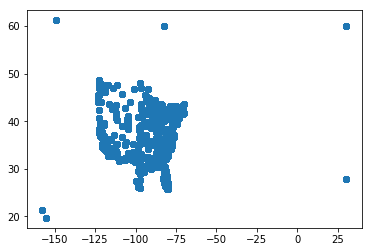

In [283]:
# Since every country listed is USA, create a scatter plot to check correctness
plt.scatter(df['long'], df['lat'])

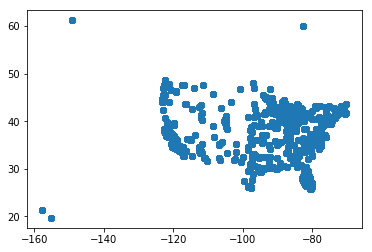

In [284]:
df = df[df['long'] < 0]
plt.scatter(df['long'], df['lat'])

The outliers in the scatter plot above on the far left at Hawaii (bottom left corner) and Alaska (upper left). However the isolated point towards top right corner is in Canada. I have tried to remove it several times and have no been successful. In the interest of time, I have left these few records in the data.

In [285]:
df['test'].value_counts()

0    176217
1     99062
Name: test, dtype: int64

In [286]:
df['converted'].value_counts()

0    270266
1      5013
Name: converted, dtype: int64

In [287]:
df['price'].value_counts()

39.0           174486
59.0            98120
721543996.0         1
361763199.0         1
361601300.0         1
361357237.0         1
722266243.0         1
361101880.0         1
722005503.0         1
721845395.0         1
721022978.0         1
359772735.0         1
720964662.0         1
720460363.0         1
720433591.0         1
720424548.0         1
720402017.0         1
360008460.0         1
719974521.0         1
719612028.0         1
362003840.0         1
536537851.0         1
724296096.0         1
724608694.0         1
727148827.0         1
727104799.0         1
726939751.0         1
726890959.0         1
726860216.0         1
363381911.0         1
                ...  
435780145.0         1
871553194.0         1
871020634.0         1
870993999.0         1
435371271.0         1
870319018.0         1
870277127.0         1
870099143.0         1
435008852.0         1
436256121.0         1
873023168.0         1
873318420.0         1
437472415.0         1
438022557.0         1
437892465.

3074 instances where the price is clearly wrong. Since that is only 0.97% of the data, drop the rows with those values.

In [288]:
df = df.drop(df[(df.price > 60)].index)

In [289]:
df['timestamp'].value_counts()

2015-04-12 11:51:16    11
2015-03-17 14:05:09    10
2015-04-24 09:44:11    10
2015-05-29 10:07:09    10
2015-04-10 08:29:07    10
2015-05-09 06:38:23     9
2015-05-02 11:14:29     9
2015-05-09 12:50:53     9
2015-05-09 05:52:57     9
2015-05-25 12:54:02     9
2015-04-10 12:20:58     9
2015-04-08 05:01:05     9
2015-05-15 08:47:44     9
2015-03-20 12:59:37     9
2015-04-19 11:06:11     9
2015-03-06 12:31:02     9
2015-04-25 18:23:07     9
2015-05-29 14:34:44     9
2015-03-26 11:59:06     9
2015-03-19 10:23:11     9
2015-03-21 18:19:19     9
2015-05-29 10:04:04     9
2015-05-25 07:27:08     9
2015-05-03 09:15:07     9
2015-05-01 18:50:10     9
2015-03-06 08:43:54     9
2015-05-22 16:45:18     8
2015-04-24 18:31:05     8
2015-04-23 17:32:38     8
2015-04-12 12:54:28     8
                       ..
2015-05-29 15:02:52     1
2015-05-24 09:01:06     1
2015-04-24 15:48:03     1
2015-04-04 09:12:59     1
2015-05-02 18:55:46     1
2015-05-08 15:36:33     1
2015-05-30 12:30:10     1
2015-04-25 0

In [290]:
df['timestamp_strng'] = df['timestamp'].apply(str)
df['time'] = df['timestamp_strng'].apply(lambda x: re.sub('60', '00', x)) 
df['datetime'] = pd.to_datetime(df['time'], errors='coerce')
df['date'] = df['datetime'].dt.date
df['weekday'] = df['datetime'].dt.dayofweek
df['hour'] = df['datetime'].dt.hour

In [291]:
df['date'] = pd.to_datetime(df['date'])

In [292]:
df['year'], df['month'], df['day'] = df['date'].dt.year, df['date'].dt.month, df['date'].dt.day

In [293]:
df['month'].value_counts()

5.0    97986
4.0    87568
3.0    86501
Name: month, dtype: int64

In [294]:
df.sort_values(['month', 'day'], ascending=[True, True])

,user_id,timestamp,source,device,operative_system,test,price,converted,city,country,...,long,timestamp_strng,time,datetime,date,weekday,hour,year,month,day
213,922037,2015-03-02 15:25:27,friend_referral,web,windows,0,39.0,0,Arvada,USA,...,-105.11,2015-03-02 15:25:27,2015-03-02 15:25:27,2015-03-02 15:25:27,2015-03-02,0.0,15.0,2015.0,3.0,2.0
303,762299,2015-03-02 09:51:19,ads_facebook,mobile,iOS,0,39.0,0,Idaho Falls,USA,...,-112.03,2015-03-02 09:51:19,2015-03-02 09:51:19,2015-03-02 09:51:19,2015-03-02,0.0,9.0,2015.0,3.0,2.0
762,109620,2015-03-02 14:34:50,ads-google,web,other,1,59.0,0,Phoenix,USA,...,-112.07,2015-03-02 14:34:50,2015-03-02 14:34:50,2015-03-02 14:34:50,2015-03-02,0.0,14.0,2015.0,3.0,2.0
1484,241249,2015-03-02 10:02:11,seo_facebook,mobile,android,0,39.0,0,New Orleans,USA,...,-89.93,2015-03-02 10:02:11,2015-03-02 10:02:11,2015-03-02 10:02:11,2015-03-02,0.0,10.0,2015.0,3.0,2.0
1643,698108,2015-03-02 21:33:33,seo-google,mobile,android,1,59.0,0,Indianapolis,USA,...,-86.15,2015-03-02 21:33:33,2015-03-02 21:33:33,2015-03-02 21:33:33,2015-03-02,0.0,21.0,2015.0,3.0,2.0
1821,964643,2015-03-02 14:06:01,seo-google,web,windows,0,39.0,0,Chicago,USA,...,-87.68,2015-03-02 14:06:01,2015-03-02 14:06:01,2015-03-02 14:06:01,2015-03-02,0.0,14.0,2015.0,3.0,2.0
2226,954044,2015-03-02 12:13:37,ads_facebook,mobile,iOS,1,59.0,0,Riverside,USA,...,-117.40,2015-03-02 12:13:37,2015-03-02 12:13:37,2015-03-02 12:13:37,2015-03-02,0.0,12.0,2015.0,3.0,2.0
2314,783999,2015-03-02 20:51:03,ads_facebook,web,windows,1,59.0,0,Bakersfield,USA,...,-119.00,2015-03-02 20:51:03,2015-03-02 20:51:03,2015-03-02 20:51:03,2015-03-02,0.0,20.0,2015.0,3.0,2.0
2380,604243,2015-03-02 12:13:37,ads_facebook,mobile,iOS,1,59.0,0,Riverside,USA,...,-117.40,2015-03-02 12:13:37,2015-03-02 12:13:37,2015-03-02 12:13:37,2015-03-02,0.0,12.0,2015.0,3.0,2.0
2381,245462,2015-03-02 00:55:47,direct_traffic,web,windows,0,39.0,0,Clarksville,USA,...,-87.35,2015-03-02 00:55:47,2015-03-02 00:55:47,2015-03-02 00:55:47,2015-03-02,0.0,0.0,2015.0,3.0,2.0


In [295]:
# dates go from March 2015 through May 2015
print('Min date: ' + format(df['date'].min() ))
print('Max date: ' + format(df['date'].max() ))
delta = df['date'].max() - df['date'].min()
print(delta)

Min date: 2015-03-02 00:00:00
Max date: 2015-05-31 00:00:00
90 days 00:00:00


In [296]:
# This will be for a histogram in the analysis section
df['moneyspent']= 0
df['moneyspent'] = np.where(df['converted'] == 1, df['price'], 0)
#df['test'].apply(lambda x: df['price'] if x ==0 else 0)

In [297]:
df

,user_id,timestamp,source,device,operative_system,test,price,converted,city,country,...,timestamp_strng,time,datetime,date,weekday,hour,year,month,day,moneyspent
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39.0,0,Buffalo,USA,...,2015-05-08 03:38:34,2015-05-08 03:38:34,2015-05-08 03:38:34,2015-05-08,4.0,3.0,2015.0,5.0,8.0,0.0
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39.0,0,Lakeville,USA,...,2015-05-10 21:08:46,2015-05-10 21:08:46,2015-05-10 21:08:46,2015-05-10,6.0,21.0,2015.0,5.0,10.0,0.0
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39.0,0,Parma,USA,...,2015-04-04 15:01:23,2015-04-04 15:01:23,2015-04-04 15:01:23,2015-04-04,5.0,15.0,2015.0,4.0,4.0,0.0
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59.0,0,Fayetteville,USA,...,2015-05-07 07:26:01,2015-05-07 07:26:01,2015-05-07 07:26:01,2015-05-07,3.0,7.0,2015.0,5.0,7.0,0.0
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39.0,0,Fishers,USA,...,2015-05-24 11:04:40,2015-05-24 11:04:40,2015-05-24 11:04:40,2015-05-24,6.0,11.0,2015.0,5.0,24.0,0.0
5,169971,2015-04-13 12:07:08,ads-google,mobile,iOS,0,39.0,0,New York,USA,...,2015-04-13 12:07:08,2015-04-13 12:07:08,2015-04-13 12:07:08,2015-04-13,0.0,12.0,2015.0,4.0,13.0,0.0
7,798371,2015-03-15 08:19:29,ads-bing,mobile,android,1,59.0,1,East Orange,USA,...,2015-03-15 08:19:29,2015-03-15 08:19:29,2015-03-15 08:19:29,2015-03-15,6.0,8.0,2015.0,3.0,15.0,59.0
8,447194,2015-03-28 12:28:10,ads_facebook,web,windows,1,59.0,0,Dayton,USA,...,2015-03-28 12:28:10,2015-03-28 12:28:10,2015-03-28 12:28:10,2015-03-28,5.0,12.0,2015.0,3.0,28.0,0.0
9,431639,2015-04-24 12:42:18,ads_facebook,web,windows,1,59.0,0,Richmond,USA,...,2015-04-24 12:42:18,2015-04-24 12:42:18,2015-04-24 12:42:18,2015-04-24,4.0,12.0,2015.0,4.0,24.0,0.0
10,590182,2015-04-17 13:30:04,ads-google,web,windows,0,39.0,0,Bloomfield Township,USA,...,2015-04-17 13:30:04,2015-04-17 13:30:04,2015-04-17 13:30:04,2015-04-17,4.0,13.0,2015.0,4.0,17.0,0.0


## Analysis <a name="analysis"></a>

In [298]:
# DESCRIPTION
length = len(df)
orig_price = len(df[df['test'] == 0])
new_price = len(df[df['test'] == 1])
pct = (float(new_price)/(length))*100

print("There are "+ str(len(df))+" cases in this dataset")
print( "There are "+ format(new_price) +" cases of new, higher price")
print("There are " + format(orig_price)+" cases of original price")
print( "The percentage of new, higher price cases is: {:.4f}%".format(pct) )

There are 272606 cases in this dataset
There are 98068 cases of new, higher price
There are 174538 cases of original price
The percentage of new, higher price cases is: 35.9743%


Based on the percentage, there is not a class imbalance issue.

In [299]:
# create new df with only those who converted, ie bought the product.
df_conv = df[df['converted'] == 1]
df_conv['test'].value_counts()

0    3452
1    1512
Name: test, dtype: int64

In [300]:
crosstab_conv = pd.crosstab(df.test, df.converted) #,margins=True)
crosstab_conv

converted,0,1
test,,
0,171086,3452
1,96556,1512


In [301]:
# Mann Whitney Test since its non-parametric
ctl = df[df['test']==0]['converted']
tst = df[df['test']==1]['converted']
print('Conversion Rate,\
    \n P-Value: {}'.format(mannwhitneyu(ctl,tst, alternative='two-sided')))
print('Mean conversion in the Control group: {0:.2f}%'.format(ctl.mean()*100))
print('Mean conversion in the Test group: {0:.2f}%'.format(tst.mean()*100))

Conversion Rate,    
 P-Value: MannwhitneyuResult(statistic=8595610932.0, pvalue=3.0587857945836604e-16)
Mean conversion in the Control group: 1.98%
Mean conversion in the Test group: 1.54%


In [302]:
# Mann Whitney Test on revenue
ctrl_rev = sum(df[df['test']==0]['converted']*39)
tst_rev = sum(df[df['test']==1]['converted']*59)
print('Conversion Rate,\
    \n P-Value: {}'.format(mannwhitneyu(ctl,tst, alternative='two-sided')))

Conversion Rate,    
 P-Value: MannwhitneyuResult(statistic=8595610932.0, pvalue=3.0587857945836604e-16)


In [303]:
# Chi-squared on crosstab
#chi2_contingency(df.test, df.converted)
display(chisquare(pd.crosstab(df.test, df.converted)))
display(chi2_contingency(pd.crosstab(df.test, df.converted)))

Power_divergenceResult(statistic=array([20754.29454271,   758.17888799]), pvalue=array([0.00000000e+000, 6.68389481e-167]))

(66.52160490673529,
 3.460795958896129e-16,
 1,
 array([[171359.76242636,   3178.23757364],
        [ 96282.23757364,   1785.76242636]]))

# Insights with regard to pricing <a name="pricing"> </a>
From the very small p-values from both the Mann-Whitney U tests & the chi-squared test, we can conclude that the means of the two groups (test & control) are very similar, which means the two groups are very associated. Thus, we cannot confidently determine whether the price should change or not. 

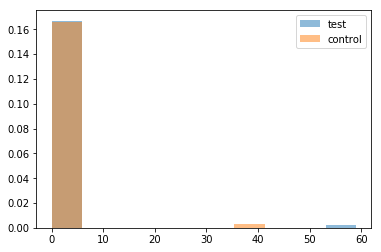

In [304]:
# Ying histogram
plt.hist(df[df['test']==1].moneyspent, label='test', density=True, alpha=0.5)
plt.hist(df[df['test']==0].moneyspent, label='control', density=True, alpha=0.5)
#plt.hist(df[df['test']==1].moneyspent, label='test', density=True, alpha=0.5)
plt.legend(loc='upper right')
plt.show()

In [305]:
conv_orig = (len(df_conv[df_conv['test'] == 0])/len(df[df['test'] == 0]))*100
conv_new = (len(df_conv[df_conv['test'] == 1])/len(df[df['test'] == 1]))*100
print("conversion rate for orig price is " + format(conv_orig))
print("conversion rate for new, higher price is " + format(conv_new))

conversion rate for orig price is 1.977792801567567
conversion rate for new, higher price is 1.541787331239548


There doesnt appear to be a huge difference in the conversion rate, 1.978% - 1.542% = 0.436%.

In [306]:
display((df_conv['device'].value_counts()/df['device'].value_counts())*100)
display((df_conv['operative_system'].value_counts()/df['operative_system'].value_counts())*100)
display((df_conv['source'].value_counts()/df['source'].value_counts())*100)

mobile    1.840709
web       1.792630
Name: device, dtype: float64

android    1.485470
iOS        2.224199
mac        2.417898
other      1.145364
windows    1.677613
Name: operative_system, dtype: float64

ads-bing           1.181503
ads-google         2.148618
ads-yahoo          1.460864
ads_facebook       2.113722
ads_other          1.451525
direct_traffic     1.223053
friend_referral    3.804867
seo-bing           2.156334
seo-google         1.686662
seo-other          1.596480
seo-yahoo          1.644904
seo_facebook       1.567037
Name: source, dtype: float64

## Takeaways & Insights from the Data<a name="takeaway"></a>
Takeaways:
- Almost equal conversion rate between mobile & web, but slightly more with mobile
- More conversion from Apple users (so iOS over android & mac over windows)
- Most conversion from friend_referrals, followed by seo-bing , ads-google, & ads_facebook.

# Efficient Test Run Time <a name="time"></a>

In [307]:
# Powertest to determine efficient number of days to run the test
df.groupby('test')['moneyspent'].describe()
#power.tt_ind_solve_power(effect_size = -0.14, alpha =0.05, power=0.8)

,count,mean,std,min,25%,50%,75%,max
test,,,,,,,,
0,174538.0,0.771912,5.435319,0.0,0.0,0.0,0.0,59.0
1,98068.0,0.909655,7.269297,0.0,0.0,0.0,0.0,59.0


In [308]:
eff_size = 0.771912 - 0.909655

# power.tt_ind_solve_power(effect_size = eff_size, alpha =0.05, power=0.8, ratio=0.36) # 1503
power.tt_ind_solve_power(effect_size = eff_size/2, alpha =0.05, power=0.8, ratio=0.5)
    #chose to do eff_size/2 to be conservative

4965.475300172909

From this power test, we know that we would need about 4966 people from the control group and 2,483 from the test group (half of the control group).

In [309]:
df_srt = df.sort_values(['month', 'day'], ascending=[True, True])
df_srt_ctrl = df_srt[df_srt['test'] == 0]
#df_srt_ctrl = df_srt_ctrl.iloc[0:1503,:]
df_srt_ctrl = df_srt_ctrl.iloc[0:4966,:]
df_srt_test = df_srt[df_srt['test'] == 1]
#df_srt_test = df_srt_test.iloc[0:1503,:]
df_srt_test = df_srt_test.iloc[0:2483,:]
df_resample = pd.concat([df_srt_ctrl, df_srt_test])
# surveys_df.iloc[0:3, 1:4]

In [310]:
#display(df_srt_ctrl['converted'].value_counts())
#display(df_srt_test['converted'].value_counts())
crosstab_conv_resample = pd.crosstab(df_resample.test, df_resample.converted) #,margins=True)
crosstab_conv_resample

converted,0,1
test,,
0,4850,116
1,2439,44


In [311]:
# quick sanity check to see if this makes sense

# Mann Whitney Test since its non-parametric
ctl_resample = df_resample[df_resample['test']==0]['converted']
tst_resample = df_resample[df_resample['test']==1]['converted']
print('Conversion Rate,\
    \n P-Value: {}'.format(mannwhitneyu(ctl_resample,tst_resample)))
print('Mean conversion in the Control group: {0:.2f}%'.format(ctl_resample.mean()*100))
print('Mean conversion in the Test group: {0:.2f}%'.format(tst_resample.mean()*100))

Conversion Rate,    
 P-Value: MannwhitneyuResult(statistic=6130527.0, pvalue=0.056801430519006796)
Mean conversion in the Control group: 2.34%
Mean conversion in the Test group: 1.77%


Recall the results from Mann-Whitney Test on entire data set:
    Conversion Rate, P-Value: MannwhitneyuResult(statistic=8595610932.0, pvalue=3.0587857945836604e-16)
Mean conversion in the Control group: 1.98%
Mean conversion in the Test group: 1.54%


Results seem to be reasonably proportional. With this assumption, we will proceed to calculate the the latest date in the resampled dataframe to determine what the reduced time frame for the test could have been.

In [312]:
max(df_resample['date'])

Timestamp('2015-03-06 00:00:00')

Thus, to get the same effect rate, the test could have run through 3/6/2015 to have gotten a test with at least 4,770 in Control group and 2,385 in Test group.
Since the test began on 3/2/2015, and by the above work, the test could have run through 3/6/2015, then the entire test period could have been 5 days instead of the 90 day period.

In [313]:
#check if 5 days makes sense (again) 
df_srt_ctrl2 = df_srt[df_srt['test'] == 0]
df_srt_ctrl2 = df_srt_ctrl2[(df_srt_ctrl2['month'] == 3)] 
df_srt_ctrl2 = df_srt_ctrl2[(df_srt_ctrl2['day'] <= 6)]
df_srt_test2 = df_srt[df_srt['test'] == 1]
df_srt_test2 = df_srt_test2[(df_srt_test2['month'] == 3)] 
df_srt_test2 = df_srt_test2[(df_srt_test2['day'] <= 6)]
df_resample2 = pd.concat([df_srt_ctrl2, df_srt_test2])

In [314]:
crosstab_conv_resample2 = pd.crosstab(df_resample2.test, df_resample2.converted) #,margins=True)
crosstab_conv_resample2

converted,0,1
test,,
0,7778,171
1,4419,73


In [315]:
# quick sanity check to see if this makes sense (again)

# Mann Whitney Test since its non-parametric
ctl_resample2 = df_resample2[df_resample2['test']==0]['converted']
tst_resample2 = df_resample2[df_resample2['test']==1]['converted']
print('Conversion Rate,\
    \n P-Value: {}'.format(mannwhitneyu(ctl_resample2,tst_resample2)))
print('Mean conversion in the Control group: {0:.2f}%'.format(ctl_resample2.mean()*100))
print('Mean conversion in the Test group: {0:.2f}%'.format(tst_resample2.mean()*100))

Conversion Rate,    
 P-Value: MannwhitneyuResult(statistic=17759526.5, pvalue=0.021050931858251982)
Mean conversion in the Control group: 2.15%
Mean conversion in the Test group: 1.63%


## Reduced test timing suggestion<a name="reducedtime"></a>
Results seem to be reasonably proportional. With this assumption, we will proceed to calculate the the latest date in the resampled dataframe to determine what the reduced time frame for the test could have been.

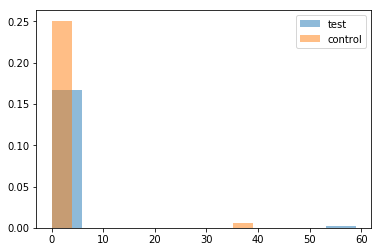

In [316]:
# Ying histogram (again)
plt.hist(df_resample2[df_resample2['test']==1].moneyspent, label='test', density=True, alpha=0.5)
plt.hist(df_resample2[df_resample2['test']==0].moneyspent, label='control', density=True, alpha=0.5)
#plt.hist(df[df['test']==1].moneyspent, label='test', density=True, alpha=0.5)
plt.legend(loc='upper right')
plt.show()

# Conclusion <a name = "conclusion"></a>

In conclusion, if the company wants to maximize revenue, then I would recommend increasing the price. However, if they prefer to maximize sales, then the recommendation would be to keep the price the same. The decision should be inline with the company's business/financial goals.

As for additional insights from the data:
- Almost equal conversion rate between mobile & web, but a bit more mobile
- More conversion from Apple users (so iOS over android & mac over windows)
- Most conversion from friend_referrals, followed by seo-bing , ads-google, & ads_facebook.

Thus, marketing/advertising could focus more on Apple users and friend_referrals.

Finally, with respect to the length of the test period (in number of days), the test ran for 90 days. 
The test could have been conducted for 5 days to see half the effect rate as was seen over the entire 90 day period, being conservative. 
Since this testing of customers cannot be rerun, I would recomment that a test period of 5 days be used going forward for the next possible test, potentially one week for simplicity.

If there was more time, I would explore the top 10-20 cities to develop more insights about the location of conversions